# Regresión

Importamos librerias a utilizar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import sklearn as sk
import matplotlib.pyplot as plt
from six import StringIO
from IPython.display import Image  
import pickle
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

Importamos las bases de datos a utilizar

In [2]:
ds_properati = pd.read_csv('dataset_properati_train.csv')
ds_properati_test = pd.read_csv('dataset_properati_test.csv')
ds_reducido_train_sin_precio = pd.read_csv("dataset_reducido_sin_price.csv")
ds_reducido_test_sin_precio = pd.read_csv("dataset_reducido_sin_price_test.csv")

ds_reducido_train_sin_precio.drop(columns='Unnamed: 0', inplace=True)
ds_reducido_test_sin_precio.drop(columns='Unnamed: 0', inplace=True)

Armamos el conjunto de train y test a partir del primer database

In [3]:
x_train = ds_properati.drop(['property_price'], axis='columns', inplace=False)
y_train = ds_properati.property_price.copy()

x_test = ds_properati_test.drop(['property_price'], axis='columns', inplace=False)
y_test = ds_properati_test.property_price.copy()

### Métricas en regresión
- MSE (Mean Square Error o error cuadrático medio)
    Medida de qué tan cercana es la recta de regresión a los puntos que representan los datos. Mientras más chico más cerca está nuestro modelo de los datos reales. Al ser un valor elevado al cuadrado, es sensible a valores de diferencias grandes.
    
    $MSE= \frac{1}{n}\sum_{i=1}^n  (y_i'-y_i)^2$
- RMSE (Root Mean Square Error o raíz del error cuadrático medio)
    
    Tiene las mismas unidades que los valores representados en el eje vertical. Es la distancia de un punto hasta la recta de regresión, medida en línea recta. Mide el desvío estándar (cuánto se alejan los valores de la media).
    
    $RMSE= \sqrt{\frac{1}{n}\sum_{i=1}^n  (y_i'-y_i)^2}$
- R²
    Es la proporción de variabilidad explicada por el modelo, se lo denomina coeficiente de determinación.
    No depende de las unidades de medida y **su valor está entre 0 y 1** .
    Cuando R² = 0 el modelo se ajusta poco a la varibilidad de los datos. Por el contrario R² = 1 se ajusta mucho a la variabilidad de los datos.
    Mientras mayor, mayor es la fuerza de la/s variable/s regresora/s para predecir la variable respuesta. Mayor es la capacidad del modelo de explicar el fenómeno.
    
    $R^2=\frac{TSS-RSS}{TSS}$ .



#### KNN


La lógica de regresión KNN es muy similar a lo que se explicó anteriormente para clasificación.
El algoritmo KNN calculará la regresión para el conjunto de datos y luego tomará la cantidad K de vecinos, verificará los resultados de esos vecinos y promediará los resultados, generando una estimación.

Primero observamos el mapa de correlacion para ver que variables pueden ser buenos features. 

In [4]:
# sns.pairplot(ds_properati)


In [5]:
#Heatmap correlación
ds_properati.corr().style.background_gradient(cmap='coolwarm')

,Unnamed: 0,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
Unnamed: 0,1.000000,-0.003331,-0.000688,-0.000753,0.000583,-0.001422,-0.001220,0.000140
latitud,-0.003331,1.000000,-0.127294,-0.173613,-0.187457,-0.141824,-0.134499,0.099474
longitud,-0.000688,-0.127294,1.000000,-0.226709,-0.223018,-0.215434,-0.201260,-0.174488
property_rooms,-0.000753,-0.173613,-0.226709,1.000000,0.896318,0.781389,0.801087,0.674202
property_bedrooms,0.000583,-0.187457,-0.223018,0.896318,1.000000,0.788178,0.802219,0.646478
property_surface_total,-0.001422,-0.141824,-0.215434,0.781389,0.788178,1.000000,0.920391,0.786862
property_surface_covered,-0.001220,-0.134499,-0.201260,0.801087,0.802219,0.920391,1.000000,0.810846
property_price,0.000140,0.099474,-0.174488,0.674202,0.646478,0.786862,0.810846,1.000000


Podemos ver que los atributos de property_surface_total y property_surface_covered podrian llegar a tener una relacion lineal.

In [6]:
#selecciono variables regresoras y a predecir
X = x_train[['property_surface_total','property_surface_covered']]
X_test = x_test[['property_surface_total','property_surface_covered']]
Y = y_train.copy()
Y_test = y_test.copy()

In [7]:
#Heatmap correlación
X.corr().style.background_gradient(cmap='coolwarm')

,property_surface_total,property_surface_covered
property_surface_total,1.000000,0.920391
property_surface_covered,0.920391,1.000000


Vemos que estan muy correlacionada

<AxesSubplot: xlabel='property_surface_total', ylabel='property_price'>

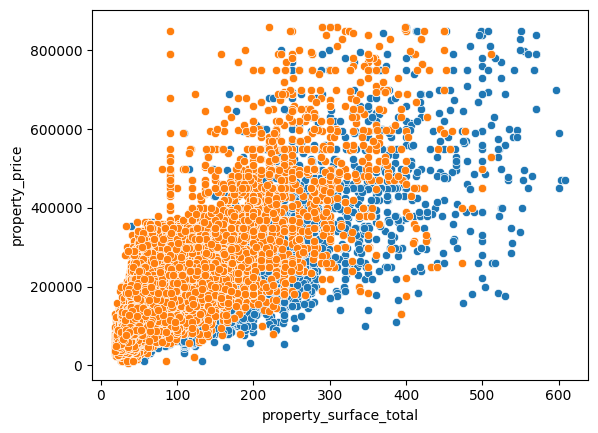

In [8]:
sns.scatterplot(x=X.property_surface_total,y=Y)
sns.scatterplot(x=X.property_surface_covered,y=Y)

Vemos que hay gran relacion lineal entre las dos.

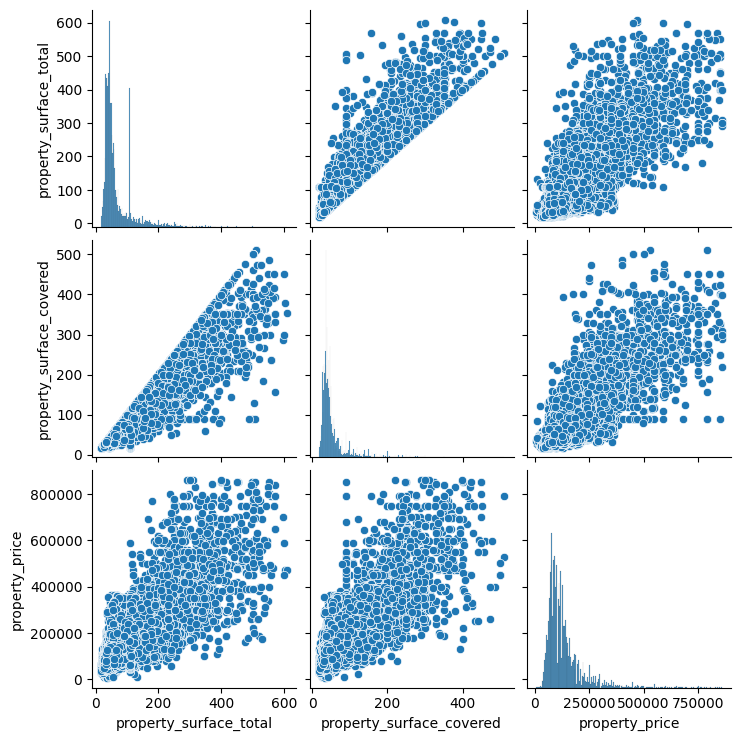

In [9]:
#Grafico de a pares incluyendo variable a predecir
xy_train = pd.concat([X, Y], axis=1)
sns.pairplot(xy_train)

Creamos un modelo KNN regresor ahora 

In [10]:
from sklearn.neighbors import KNeighborsRegressor

# Creo un modelo KNN para regresion y lo ajusto
knn_regressor = KNeighborsRegressor().fit(X, Y)

#Hago una predicción
y_pred=knn_regressor.predict(X_test)

Comparamos la performance del Clasificador Regresor

In [11]:
# Performance
performance = pd.DataFrame({'Valor Real': Y_test,
                            'Prediccion': y_pred,
                            'Error': abs(Y_test - y_pred)})
# View
performance.head(10)

,Valor Real,Prediccion,Error
0,220000.0,259000.0,39000.0
1,90000.0,73180.0,16820.0
2,85000.0,103578.0,18578.0
3,144000.0,168000.0,24000.0
4,105000.0,101260.0,3740.0
5,45900.0,68028.0,22128.0
6,155000.0,136000.0,19000.0
7,89000.0,110800.0,21800.0
8,47000.0,55580.0,8580.0
9,134000.0,135700.0,1700.0


Observamos que tenemos un poco de error en las predicciones. Procedemos a buscar los mejores parametros

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition, datasets
from sklearn import neighbors
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

In [13]:
n_neighbors = [2, 3, 5, 10]
algorithm = ["auto",  "ball_tree", "kd_tree", "brute"]

parameters = {'weights':['uniform', 'distance'],
            'algorithm': algorithm,
                'n_neighbors': n_neighbors,
                'leaf_size': [20,22,23,30],
                'p' : [1,2],
                }
knn_regressor = KNeighborsRegressor()

In [14]:
clf = RandomizedSearchCV(knn_regressor, parameters, random_state=2, scoring='r2')
clf.fit(X, Y)

RandomizedSearchCV(estimator=KNeighborsRegressor(),
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [20, 22, 23, 30],
                                        'n_neighbors': [2, 3, 5, 10],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=2, scoring='r2')

Usamos la métrica de R2 para hallar los mejores parámetros porque nos da una explicación general de la capacidad de predecir de un modelo. Va de 0 a 1, cuanto mas cerca de 1, es la fuerza de la/s variable/s regresora/s para predecir la variable respuesta. Esta es el score por default de KNN regresión.

In [15]:
print(); print("los mejores parametros son: ",clf.best_params_)

CV_Result = cross_val_score(clf, X, Y, cv=3, n_jobs=-1)
print(); print(CV_Result)
print(); print("la media es: ",CV_Result.mean())
print(); print("el desvio estandar es: ",CV_Result.std())


los mejores parametros son:  {'weights': 'distance', 'p': 1, 'n_neighbors': 10, 'leaf_size': 20, 'algorithm': 'brute'}

[0.68928975 0.69102199 0.67750698]

la media es:  0.6859395733470305

el desvio estandar es:  0.006004535227115078


In [16]:
# Creo un modelo KNN para regresion y lo ajusto
knn_regressor = KNeighborsRegressor().fit(X, Y)

#Hago una predicción
y_pred_train = knn_regressor.predict(X)

Comparamos con el conjunto de entrenamiento

In [17]:
# Performance
performance = pd.DataFrame({'Valor Real': Y,
                            'Prediccion': y_pred_train,
                            'Error':abs(Y - y_pred_train) })
print(performance)

       Valor Real  Prediccion     Error
0         79000.0    112738.0   33738.0
1         99000.0    135700.0   36700.0
2        160000.0    130286.4   29713.6
3        153000.0    155000.0    2000.0
4        159000.0    116613.8   42386.2
...           ...         ...       ...
39714    126900.0     85780.0   41120.0
39715    185000.0    117780.0   67220.0
39716    795000.0    482600.0  312400.0
39717    125000.0    161089.2   36089.2
39718     77000.0     73780.0    3220.0

[39719 rows x 3 columns]


Evaluamos las metricas en el conjunto de entrenamiento

In [18]:
from sklearn import metrics

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = Y,
        y_pred  = y_pred_train,
        squared = True                                                                                                                                                                                                                                                                                                                                                    
       )
print(f"El error (mse) de test es: {mse}")
#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = Y,
        y_pred  = y_pred_train,
        squared = False
       )                                                    
print(f"El error (rmse) de test es: {rmse}")
#Coef. de Determinación R2
score_knn = knn_regressor.score(X, Y)
print("El score es de: ",score_knn)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

El error (mse) de test es: 1939108297.1555963
El error (rmse) de test es: 44035.30739254123
El score es de:  0.7427530690063386


Comparamos con el conjunto de test

In [19]:
y_pred_test = knn_regressor.predict(X_test)

# Performance
performance = pd.DataFrame({'Valor Real': Y_test,
                            'Prediccion': y_pred_test,
                            'Error':abs(Y_test - y_pred_test) })
print(performance)

      Valor Real  Prediccion    Error
0       220000.0    259000.0  39000.0
1        90000.0     73180.0  16820.0
2        85000.0    103578.0  18578.0
3       144000.0    168000.0  24000.0
4       105000.0    101260.0   3740.0
...          ...         ...      ...
9861     85000.0    103000.0  18000.0
9862    275000.0    228000.0  47000.0
9863    143900.0    120760.0  23140.0
9864    139500.0    128100.0  11400.0
9865    300000.0    290800.0   9200.0

[9866 rows x 3 columns]


In [20]:
#Exportamos el modelo
knn = 'models/knn_regresion.sav'
pickle.dump(knn_regressor, open(knn, 'wb'))

Evaluamos las metricas en el conjunto de test

In [21]:
from sklearn import metrics

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = Y_test,
        y_pred  = y_pred_test,
        squared = True
       )
print(f"El error (mse) de test es: {mse}")
#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = Y_test,
        y_pred  = y_pred_test,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")
#Coef. de Determinación R2
score_knn = knn_regressor.score(X_test, Y_test)
print("El score es de: ",score_knn)

El error (mse) de test es: 2501714724.9272447
El error (rmse) de test es: 50017.144309998796
El score es de:  0.654312073958502


El score dio prácticamente idéntico tanto para la predicción de los datos de test como de train.

Vamos a entrenar el modelo sobre el ds reducido con PCA en el que eliminamos la variable target (property_price):

In [22]:
knn_pca = knn_regressor.fit(ds_reducido_train_sin_precio, Y)
y_pca_train = knn_pca.predict(ds_reducido_train_sin_precio)
y_pca_test = knn_pca.predict(ds_reducido_test_sin_precio)

In [23]:
#Exportamos el modelo sobre el ds reducido
knn_pca = 'models/knn_regresion_reducido.sav'
pickle.dump(knn_pca, open(knn_pca, 'wb'))

Evaluamos las métricas para train

In [24]:
from sklearn import metrics

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = Y,
        y_pred  = y_pca_train,
        squared = True)

print(f"El error (mse) de train es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = Y,
        y_pred  = y_pca_train,
        squared = False
       )
print(f"El error (rmse) de train es: {rmse}")
#Coef. de Determinación R2
score_knn = knn_regressor.score(ds_reducido_train_sin_precio, y_pca_train)
print("El score es de: ",score_knn)

El error (mse) de train es: 974887883.7694603
El error (rmse) de train es: 31223.194643877494
El score es de:  1.0


Y para test

In [25]:
from sklearn import metrics

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = Y_test,
        y_pred  = y_pca_test,
        squared = True)

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = Y_test,
        y_pred  = y_pca_test,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")
#Coef. de Determinación R2
score_knn = knn_regressor.score(ds_reducido_test_sin_precio, y_pca_test)
print("El score es de: ",score_knn)


El error (mse) de test es: 1558734161.4748995
El error (rmse) de test es: 39480.80750788793
El score es de:  1.0


### XG BOOST

XGBoost es una forma más regularizada de Gradient Boosting . XGBoost utiliza la regularización avanzada (L1 y L2), que mejora las capacidades de generalización del modelo.

Ofrece un alto rendimiento en comparación con Gradient Boosting. Su entrenamiento es muy rápido y se puede paralelizar entre clústeres.

Fue diseñado para Big Data, es decir para conjuntos de datos grandes y complejos.

XG Boost puede usarse para problemas de regresión o de clasificación.

Pasos:



1. Hacer una predicción inicial. Esta predicción puede ser cualquier valor.
2. Construir un árbol para los residuos. Este árbol es diferente a los usados por Gradient Boost. Primero se crea un nodo hoja y se ponen allí **todos** los residuos.
3. Calcular el ***Similarity Score***, para los residuos: $Similarity Score=\frac{(\sum{residuos)^2}}{\#residuos + \lambda}$
4. Tenemos que ver cuál será el siguiente nodo. Para ello vamos a calcular la **ganancia total** (Gain), según escojamos una opción u otra para partir el árbol (qué umbral tomemos). Nos quedamos con el umbral que de la mayor información ganada.
5. Repetimos el anterior hasta alcanzar la profundidad del árbol estipulada.
6. Poda:
    - Elegimos un número al azar → este número se llama gamma ( **𝜸** )
    - Calculamos la diferencia entre el **Gain** del nodo más bajo y **gamma**
    - Si la diferencia es < 0 → removemos el nodo
    - Sino, el nodo se queda y se terminó la poda
7. Volvemos a calcular el árbol (repite paso 3), solo que esta vez usamos lambda 𝛌 igual a 1 al calcular el Similarity Score y el Gain.
8. Podamos (paso quinto nuevamente).
9. Con estos nuevos residuos, construimos un nuevo árbol.
Repetimos todo, desde el paso 2.
Con el nuevo árbol, calculamos la salida de cada elemento y luego los residuos.
Construimos otro árbol.
Seguimos hasta que los residuos son prácticamente cero o bien alcanzamos el número máximo de árboles predefinido.

 Hiper-parámetros

learning_rate: tasa de aprendizaje

max_depth: máxima profundidad de cada árbol

subsample: porcentaje de muestras usadas para cada árbol (valor muy bajo, posible underfitting)

colsample_bytree: porcentaje de features usadas para cada árbol (valores muy alto, posible overfitting)

n_estimators: cantidad de árboles a construir.

objective: función de error a utilizar (algunas: reg:linear para regresión, reg:logistic, binary:logistic para clasificación)

Parámetros de regularización:

gamma: umbral para hacer split basado en la reducción de error de hacer el nuevo split.

alpha: regularización para los pesos de las hojas. Un valor más alto genera una mayor regularización.

lambda: similar alpha pero para la sintonia fina.

Los parametros se agregan al modelo para evitar el overfitting



Creamos el modelo

In [26]:
!pip install xgboost==1.6.2

  Using cached xgboost-1.6.2-py3-none-manylinux2014_x86_64.whl (255.9 MB)
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.0
    Uninstalling xgboost-1.7.0:
      Successfully uninstalled xgboost-1.7.0
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [27]:
ds_properati = pd.read_csv('dataset_properati_train.csv')
ds_properati_test = pd.read_csv('dataset_properati_test.csv')

x_train = ds_properati.drop(['property_price'], axis='columns', inplace=False)
y_train = ds_properati.property_price.copy()

x_test = ds_properati_test.drop(['property_price'], axis='columns', inplace=False)
y_test = ds_properati_test.property_price.copy()

X = x_train[['property_surface_total','property_surface_covered']]
X_test = x_test[['property_surface_total','property_surface_covered']]
Y = y_train.copy()
Y_test = y_test.copy()

In [28]:
X.columns

Index(['property_surface_total', 'property_surface_covered'], dtype='object')

In [29]:
#Creo el modelo y lo entreno
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

xgb_model = xgb.XGBRegressor(random_state=0, n_estimators=100)
xgb_model.fit(X, Y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Evaluamos sobre el conjunto de entrenamiento

In [30]:
y_pred_train=xgb_model.predict(X)

Ahora evaluamos sobre el conjunto de test para observar su prediccion

In [31]:
y_pred_test=xgb_model.predict(X_test)

Calculamos el error para cada predicción:

In [32]:
score_train = xgb_model.score(X, Y)  
print("Score de training: ", score_train)
score_test = xgb_model.score(X_test,Y_test)
print("Score de test: ", score_test)

ypred_train = xgb_model.predict(X)
mse_train = mean_squared_error(Y, ypred_train)
print("MSE train: %.2f" % mse_train)
print("RMSE train: %.2f" % (mse_train**(1/2.0)))
ypred_test = xgb_model.predict(X_test)
mse_test = mean_squared_error(Y_test, ypred_test)
print("MSE test: %.2f" % mse_test)
print("RMSE test: %.2f" % (mse_test**(1/2.0)))


Score de training:  0.7880161858133388
Score de test:  0.6795699002470665
MSE train: 1597918277.84
RMSE train: 39973.97
MSE test: 2318925940.06
RMSE test: 48155.23


Vemos que obtienen valores similares para los dos conjuntos. Por un lado, mientras mas cerca a 1 es el score, mejor fitea la linea de regresion a los datos, y por ende mejor modelo.

Ahora optimizamos los hiperparametros a través de KFold cross validation con 5 folds con la metrica Mean Absolute Error

In [33]:
from sklearn.metrics import mean_absolute_error
params = {
    'n_estimators':[50, 20],
    'min_child_weight':[4,5], 
    'gamma':[i/10.0 for i in range(3,4)],  
    'subsample':[i/10.0 for i in range(6,8)],
    'colsample_bytree':[i/10.0 for i in range(6,8)], 
    'max_depth': [2,4,7],
    'objective': ['reg:squarederror', 'reg:tweedie', 'reg:linear'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': [mean_absolute_error],
    'eta': [i/10.0 for i in range(3,4)],
}

reg = xgb.XGBRegressor(nthread=-1, random_state=2)

# run randomized search

random_search = RandomizedSearchCV(reg, param_distributions=params,
                                    cv=5, scoring='neg_mean_squared_error', random_state=2)

random_search.fit(X, y_train)


[03:27:34] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:27:34] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:27:34] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                   param_distributions={'booster': ['gbtree', 'gblinear'],
                                        'colsample_bytree': [0.6, 0.7],
                                        'eta': [0.3],
                                        'eval_metric': [<function mean_absolute_error at 0x7f6dd066a430>],
                                        'gamma': [0.3], 'max_depth': [2, 4, 7],
                                        'min_child_weight': [4, 5],
                                        'n_estimators': [50, 20],
                                        'objective': ['reg:squarederror',
                                                      'reg:tweedie',
                                                      'reg:linear'],
                                        'subsample': [0.6, 0.7]},
                   random_state=2, scoring='neg_mean_squared_error')

In [34]:
display(random_search.best_params_)
xgbmodel_cv = random_search.best_estimator_

{'subsample': 0.7,
 'objective': 'reg:tweedie',
 'n_estimators': 50,
 'min_child_weight': 4,
 'max_depth': 2,
 'gamma': 0.3,
 'eval_metric': <function sklearn.metrics._regression.mean_absolute_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'eta': 0.3,
 'colsample_bytree': 0.6,
 'booster': 'gbtree'}

Estos serian los mejores parametros para xgboost

Ahora hacemos predicciones con los conjuntos y evaluamos la performance

In [35]:
y_train_pred_cv = xgbmodel_cv.predict(X)
y_test_pred_cv = xgbmodel_cv.predict(X_test)

In [36]:
#Exportamos el modelo
xgb = 'models/xgb_regressor.sav'
pickle.dump(xgbmodel_cv, open(xgb, 'wb'))

In [37]:
score_train = xgbmodel_cv.score(X, Y)  

print("Score de training: ", score_train)
score_test = xgbmodel_cv.score(X_test,Y_test)
print("Score de test: ", score_test)
mse_train = mean_squared_error(Y, y_train_pred_cv)
mse_test = mean_squared_error(Y_test, y_test_pred_cv)
print("MSE train: %.2f" % mse_train)

print("MSE test: %.2f" % mse_test)
print("RMSE test: %.2f" % (mse_test**(1/2.0)))
print("RMSE train: %.2f" % (mse_train**(1/2.0)))

Score de training:  0.6998832236835746
Score de test:  0.6684943411654958
MSE train: 2262258013.43
MSE test: 2399078838.53
RMSE test: 48980.39
RMSE train: 47563.20


Aunque entrenamos el modelo con la metrica de RMSE y ahora con la MSE, no observamos mejora por sobre el score del train y test.

Xg boost tiene también métricas para evaluar, RMSE, MSE y R2 ya las explicamos arriba.

- El error porcentual absoluto medio (MAPE), también conocido como desviación promedio absoluta porcentual (MAPD), mide la exactitud de un método para la construcción ajustada de valores de serie de tiempo en estadísticas. Con la formula


![Picture title](image-20221101-214052.png)

- Error: Calculado como mal predichas / total de casos

Entrenamos el modelo con el set reducido por PCA:

In [38]:
xgb_red = xgbmodel_cv.fit(ds_reducido_train_sin_precio, y_train)
y_pred_pca_train = xgb_red.predict(ds_reducido_train_sin_precio)
y_pred_pca_test = xgb_red.predict(ds_reducido_test_sin_precio)

In [39]:
#Exportamos el modelo sobre el ds de pca
xgb = 'models/xgb_regressor_reducido.sav'
pickle.dump(xgb_red, open(xgb, 'wb'))

Observamos las metricas con el conjunto de train y test del ds reducido

In [40]:
score_pca_train = xgbmodel_cv.score(ds_reducido_train_sin_precio, Y)
print("Score de training: ", score_train)
score_test = xgbmodel_cv.score(ds_reducido_test_sin_precio,Y_test)
print("Score de test: ", score_test)
mse_train = mean_squared_error(Y, y_train_pred_cv)
mse_test = mean_squared_error(Y_test, y_test_pred_cv)
print("MSE train: %.2f" % mse_train)

print("MSE test: %.2f" % mse_test)
print("RMSE test: %.2f" % (mse_test**(1/2.0)))
print("RMSE train: %.2f" % (mse_train**(1/2.0)))

Score de training:  0.6998832236835746
Score de test:  0.6942245071644777
MSE train: 2262258013.43
MSE test: 2399078838.53
RMSE test: 48980.39
RMSE train: 47563.20


### Gradient Boost

Gradient Boost puede usarse para problemas de regresión o de clasificación.

Gradient Boost comienza con un nodo hoja, luego construye árboles pero de más de un nivel y todos aportan lo mismo a la clasificación final (no tienen pesos). Se construyen tantos árboles como se solicite o hasta que los árboles adicionales no logren mejorar el ajuste.

Permite elegir una función de costo L, por ejemplo, error cuadrático medio si es un problema de regresión y cada árbol que construye lo hace de manera que la función de costo se minimice (técnica de optimización que se denomina descenso por gradiente).

En cada iteración construimos un árbol nuevo que aprenda a predecir el residuo (error) entre las observaciones y los valores predichos por el árbol anterior.

Finalmente para estimar un nuevo valor, cuando el método termina de entrenar, procedemos como antes, usando el valor inicial y sumando los residuos ponderados (por un valor constante learning rate) de cada árbol.

Parámetros específicos del árbol: afectan a cada árbol individual del modelo.

- Criterio de elección de atributos en cada nodo (ganancia de la información o gini)
- Criterio de parada (ej: máxima profundidad generalmente se usa 5 o 6)
- Estrategia de poda

Parámetros de boosting: estos afectan la operación de boosting en el modelo.

- learning_rate (por defecto=0.1): la tasa de aprendizaje reduce la contribución de cada árbol → maneja el overfitting. Hay una compensación entre learning_rate y la cantidad de estimadores. Es un valor entre 0 y 1. Tendrá una varianza baja.
- n_estimators (por defecto=100): cantidad de estimadores que se van a utilizar.

Importamos las librerias a usar en Gradient Boosting

In [41]:
!pip install xgboost==1.7.0

  Using cached xgboost-1.7.0-py3-none-manylinux2014_x86_64.whl (193.6 MB)
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.6.2
    Uninstalling xgboost-1.6.2:
      Successfully uninstalled xgboost-1.6.2
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [42]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

Construimos un modelo con el target. 

In [65]:
gb_model = GradientBoostingRegressor(random_state=2)
gb_model.fit(X, Y)

GradientBoostingRegressor(random_state=2)

In [71]:
#R² en train
print("Model Accuracy train: %.3f" % gb_model.score(X, Y))
mse = mean_squared_error(Y, gb_model.predict(X))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Model Accuracy train: 0.716
The mean squared error (MSE) on test set: 2139015700.3037


Evaluamos el modelo en el conjunto de test

In [69]:
#R² 
print("Model Accuracy test: %.3f" % gb_model.score(X_test, Y_test))
mse = mean_squared_error(Y_test, gb_model.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Model Accuracy: 0.677
The mean squared error (MSE) on test set: 2335368492.9379


In [56]:
sk.metrics.get_scorer_names() #vemos las métricas que podemos usar para entrenar con cv (sólo las de regresión en este caso)

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

Intentamos optimizar hiperparámetros para obtener mejores resultados

In [78]:
#Parámetros a optimizar
params_grid = {'n_estimators':range(20, 150, 5), 'max_depth':range(1,7), 'learning_rate':np.arange(0,1,0.001)}

#Folds
kfoldcv = StratifiedKFold(n_splits=5)

#Ramdom Search CV
randomcv = RandomizedSearchCV(GradientBoostingRegressor(random_state=2), params_grid, n_jobs=4, scoring='r2',cv=kfoldcv, n_iter=10,random_state=2,error_score='raise')
randomcv.fit(X,Y)

print(randomcv.best_params_)

#Mejor Modelo
gb = randomcv.best_estimator_

{'n_estimators': 145, 'max_depth': 5, 'learning_rate': 0.227}


In [74]:
#predigo train y test
y_pred_train = gb.predict(X)
y_pred_test = gb.predict(X_test)
# Performance
performance = pd.DataFrame({'Valor Real': Y,
                            'Prediccion': y_pred_train,
                            'Error':abs(Y - y_pred_train) })
print(performance)

       Valor Real     Prediccion          Error
0         79000.0  117083.295082   38083.295082
1         99000.0  105749.450062    6749.450062
2        160000.0  154424.810404    5575.189596
3        153000.0  145392.004687    7607.995313
4        159000.0  133404.990765   25595.009235
...           ...            ...            ...
39714    126900.0   85241.932161   41658.067839
39715    185000.0  117361.855590   67638.144410
39716    795000.0  679170.115980  115829.884020
39717    125000.0  136896.151428   11896.151428
39718     77000.0   79687.049489    2687.049489

[39719 rows x 3 columns]


In [64]:
#métricas sobre train y test
score_train_gb = gb.score(X, Y)
print("Score de training (R²): ", score_train_gb)
score_test_gb = gb.score(X_test,Y_test)
print("Score de test: ", score_test_gb)
mse_train = mean_squared_error(Y, y_pred_train)
mse_test = mean_squared_error(Y_test, y_pred_test)
print("MSE train: %.2f" % mse_train)

print("MSE test: %.2f" % mse_test)
print("RMSE test: %.2f" % (mse_test**(1/2.0)))
print("RMSE train: %.2f" % (mse_train**(1/2.0)))

Score de training (R²):  0.7826318867807627
Score de test:  0.6772725354018412
MSE train: 1638504724.83
MSE test: 2335551778.07
RMSE test: 48327.55
RMSE train: 40478.45


In [ ]:
Si bien en train pasamos de 0.71 a 0.78 como score (medido como R²) en test termina funcionando igual que el anterior con un 0.68

In [75]:
#exportamos el modelo
gb_file = 'models/gb.sav'
pickle.dump(gb, open(gb_file, 'wb'))

In [79]:
#entrenamos sobre el ds reducido
gb_pca = gb.fit(ds_reducido_train_sin_precio, Y)
#evaluamos en train
y_pred_pca_train = gb_pca.predict(ds_reducido_train_sin_precio)
#evaluamos en test
y_pred_pca_test = gb_pca.predict(ds_reducido_test_sin_precio)

In [80]:
#métricas sobre train y test en el ds de pca
score_train_gb_pca = gb_pca.score(ds_reducido_train_sin_precio, Y)
print("Score de training (R²): ", score_train_gb_pca)
score_test_gb_pca = gb_pca.score(ds_reducido_test_sin_precio,Y_test)
print("Score de test: ", score_test_gb_pca)
mse_train = mean_squared_error(Y, y_pred_pca_train)
mse_test = mean_squared_error(Y_test, y_pred_pca_test)
print("MSE train: %.2f" % mse_train)

print("MSE test: %.2f" % mse_test)
print("RMSE test: %.2f" % (mse_test**(1/2.0)))
print("RMSE train: %.2f" % (mse_train**(1/2.0)))

Score de training (R²):  0.8642209793741582
Score de test:  0.78742655711986
MSE train: 1023492192.73
MSE test: 1538376298.74
RMSE test: 39222.14
RMSE train: 31992.06


Asombrosamente vemos que trabajando con un ds mucho más chico en columnas, las métricas mejoran mucho porque no bajan tanto en test respecto a train como en el otro caso.

In [81]:
#exportamos el modelo
gb_file_pca = 'models/gb_reducido.sav'
pickle.dump(gb_pca, open(gb_file_pca, 'wb'))

### Modelo que elegiriamos

Tomando en cuenta las metricas de cada modelo:

KNN: 

*poner foto de las metricas*

XGB:

*poner foto de las metricas*

GB:

*poner foto de las metricas*

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fcb02109-3268-4805-81b4-1fba96795907' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>